In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067.pgm
/kaggle/input/mias-mammography/all-mias/mdb023.pgm
/kaggle/input/mias-mammography/all-mias/mdb073.pgm
/kaggle/input/mias-mammography/all-mias/mdb307.p

In [79]:
no_angles = 360
url ='/kaggle/input/mias-mammography/all-mias/'

In [80]:
def save_dictionary(path,data):
    print('saving catalog...')
    #open('u.item', encoding="utf-8")
    import json
    with open(path,'w') as outfile:
      json.dump(str(data), fp=outfile)
      # save to file:
    print(' catalog saved')

In [81]:
def read_image():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        # print(image_name)
        image_address= url+image_name+'.pgm'
        #print(image_address)
        #print(image_address)
        img = cv2.imread(image_address, 0)
        # print(i)
        img = cv2.resize(img, (64,64))   #resize image
        rows, cols = img.shape
        info[image_name]={}
        for angle in range(no_angles):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle]=img_rotated
    return (info)

In [82]:
def read_lable():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')       
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,1):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,1):
                    info[words[0]][angle] = 1            
        if len(words)>2:
            if (words[2] == 'NORM'):
                info[words[0]] = {}
                for angle in range(0,no_angles,1):
                    info[words[0]][angle] = 2
        
    return (info)

In [83]:
data=read_lable()

Reading labels


In [84]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
lable_info=read_lable()
image_info=read_image()
#print(image_info[1][0])
ids=lable_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
del lable_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,1):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,3)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
(a,b,c)=x_train.shape  # (60000, 28, 28)
x_train = np.reshape(x_train, (a, b, c, 1))  #1 for gray scale
(a, b, c)=x_test.shape
x_test = np.reshape(x_test, (a, b, c, 1))   #1 for gray scale
# cancer_prediction_cnn(x_train, y_train, x_test, y_test)

Reading labels
Reading images


In [85]:
#%% BALANCING THE DATA DURING TRAIN
from sklearn.utils import compute_class_weight

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 1.7045492142266336, 1: 2.0588783801785002, 2: 0.5187708728413916}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[2 0 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [86]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
model = Sequential()

#     model.add(Conv2D(32, (3, 3), input_shape=(rows, cols, 1)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(32, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
#     model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1),input_shape=(rows,cols,1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
activation_15 (Activation)   (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
activation_16 (Activation)   (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)       

In [87]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

In [88]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.2, epochs=100, batch_size=128,callbacks=[es],class_weight=d_class_weights)
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/100
580/580 [==============================] - 8s 14ms/step - loss: 1.4435 - accuracy: 0.3477 - val_loss: 1.0691 - val_accuracy: 0.4331
Epoch 2/100
580/580 [==============================] - 7s 12ms/step - loss: 1.0729 - accuracy: 0.4148 - val_loss: 1.0498 - val_accuracy: 0.4342
Epoch 3/100
580/580 [==============================] - 7s 12ms/step - loss: 1.0396 - accuracy: 0.4409 - val_loss: 1.0240 - val_accuracy: 0.4352
Epoch 4/100
580/580 [==============================] - 7s 12ms/step - loss: 1.0035 - accuracy: 0.4595 - val_loss: 0.9645 - val_accuracy: 0.4940
Epoch 5/100
580/580 [==============================] - 7s 13ms/step - loss: 0.9624 - accuracy: 0.4823 - val_loss: 0.9448 - val_accuracy: 0.4917
Epoch 6/100
580/580 [==============================] - 7s 12ms/step - loss: 0.9238 - accuracy: 0.5071 - val_loss: 0.9257 - val_accuracy: 0.5151
Epoch 7/100
580/580 [==============================] - 7s 12ms/step - loss: 0.8832 - accuracy: 0.5325 - val_loss: 0.8590 - val_accuracy:

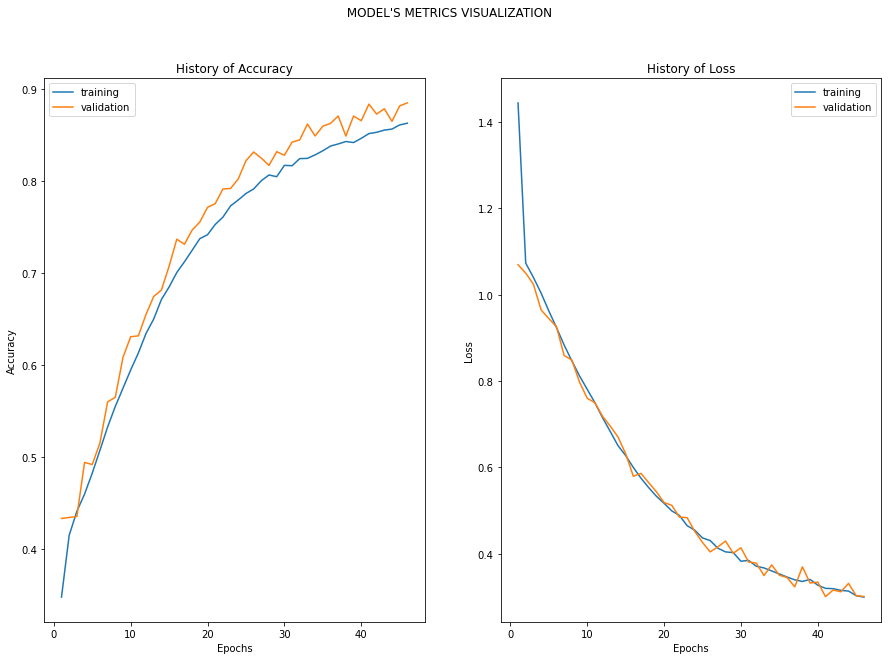

In [89]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [90]:
y_pred=model.predict_classes(x_test)
y_test=[np.argmax(x) for x in y_test]
y_pred_prb=model.predict_proba(x_test)

In [91]:
print(y_test)
print(y_pred)

[1, 2, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 0, 0, 2, 0, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 2, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 0, 2, 0, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 

In [92]:
# def print_performance_metrics(y_test,y_pred):
#     """
#         parameters
#         ----------
#         y_test : actual label (must be in non-one hot encoded form)
#         y_pred_test : predicted labels (must be in non-one hot encoded form, common output of predict methods of classifers)

#         returns
#         -------
#         prints the accuracy, precision, recall, F1 score, ROC AUC score, Cohen Kappa Score, Matthews Corrcoef and classification report   
    
#     """
target=["B","M","N"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.8839
Precision: 0.8915
Recall: 0.8839
F1 Score: 0.8857
ROC AUC Score: 0.972
Cohen Kappa Score: 0.7862
		Classification Report:
               precision    recall  f1-score   support

           B       0.79      0.88      0.83      4545
           M       0.78      0.91      0.84      3706
           N       0.95      0.88      0.91     14933

    accuracy                           0.88     23184
   macro avg       0.84      0.89      0.86     23184
weighted avg       0.89      0.88      0.89     23184

